# Lecture 5: Parallel programming in Julia

by Valentin Churavy, based on material for MIT 18.337
https://slides.com/valentinchuravy/julia-parallelism

## Levels of parallelism

1. Instruction level parallelism *(Not a topic today)*
2. Vector instructions *(Not a topic today)*
3. Threading (shared-memory)
4. Distributed
5. Accelerators e.g. GPGPU

## Benchmarking methodology

1. Measure first! Don't try to guess the performance of your code.
2. If you don't measure, you can't improve.
3. Computers are noisy! Many people use lowest runtime.
4. Read the performance tips in the Julia manual.
5. Don't benchmark in global scope.
6. Global variables are performance pitfalls.

### Steps
1. Check for type instabilities with `@code_warntype`
2. Benchmark using `@btime` and `@benchmark` from `BenchmarkTools.jl`
3. Use Julia profiler and `ProfileView.jl`
4. Use the memory allocation tracker

### About global scope
A global variable might have its value, and therefore its type, change at any given point. This makes it difficult/nigh impossible for the compiler to reason about/optimize code using global variables.

Julia uses functions as its compilation unit and any code that is performance critical or being benchmarked should be inside a function.

In [1]:
using BenchmarkTools

@benchmark sin(1)

In [2]:
 @benchmark sum(rand(1000))

BenchmarkTools.Trial: 
  memory estimate:  7.94 KiB
  allocs estimate:  1
  --------------
  minimum time:     1.864 μs (0.00% GC)
  median time:      2.438 μs (0.00% GC)
  mean time:        2.803 μs (6.68% GC)
  maximum time:     175.963 μs (93.93% GC)
  --------------
  samples:          10000
  evals/sample:     10

In [3]:
@benchmark sum($(rand(1000)))

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     116.759 ns (0.00% GC)
  median time:      117.104 ns (0.00% GC)
  mean time:        117.527 ns (0.00% GC)
  maximum time:     179.316 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     916

Always interpolate inputs into your benchmark to measure the part of your code that you are interested in.

# Using the Julia profiler
```
@profile fun() # Profile a specific function
Profile.clear() # Clear the recorded profile
Profile.print() # Print the recorded profile
Profile.print(C=true) # Print the profile including calls into C

# The textual output of the profiler can be hard to understand
# ProfileView.jl gives you a graphical representation
using ProfileView
ProfileView.view()
```

In [4]:
function profile_test(n)
    for i = 1:n
        A = randn(100,100,20)
        m = maximum(A)
        Afft = fft(A)
        Am = mapslices(sum, A, 2)
        B = A[:,:,5]
        Bsort = mapslices(sort, B, 1)
        b = rand(100)
        C = B.*b
    end
end

profile_test(1);  # run once to trigger compilation

In [5]:
Profile.clear()  # in case we have any previous profiling data
@profile profile_test(100)

In [6]:
using ProfileView

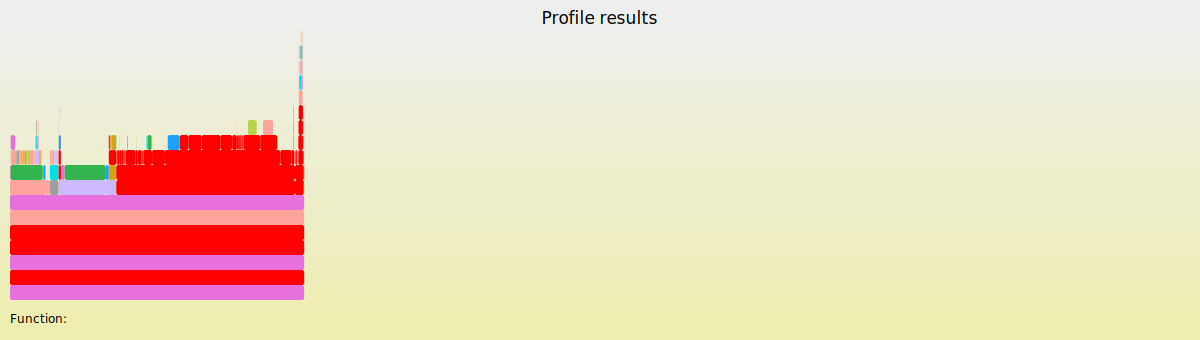

In [7]:
ProfileView.view()

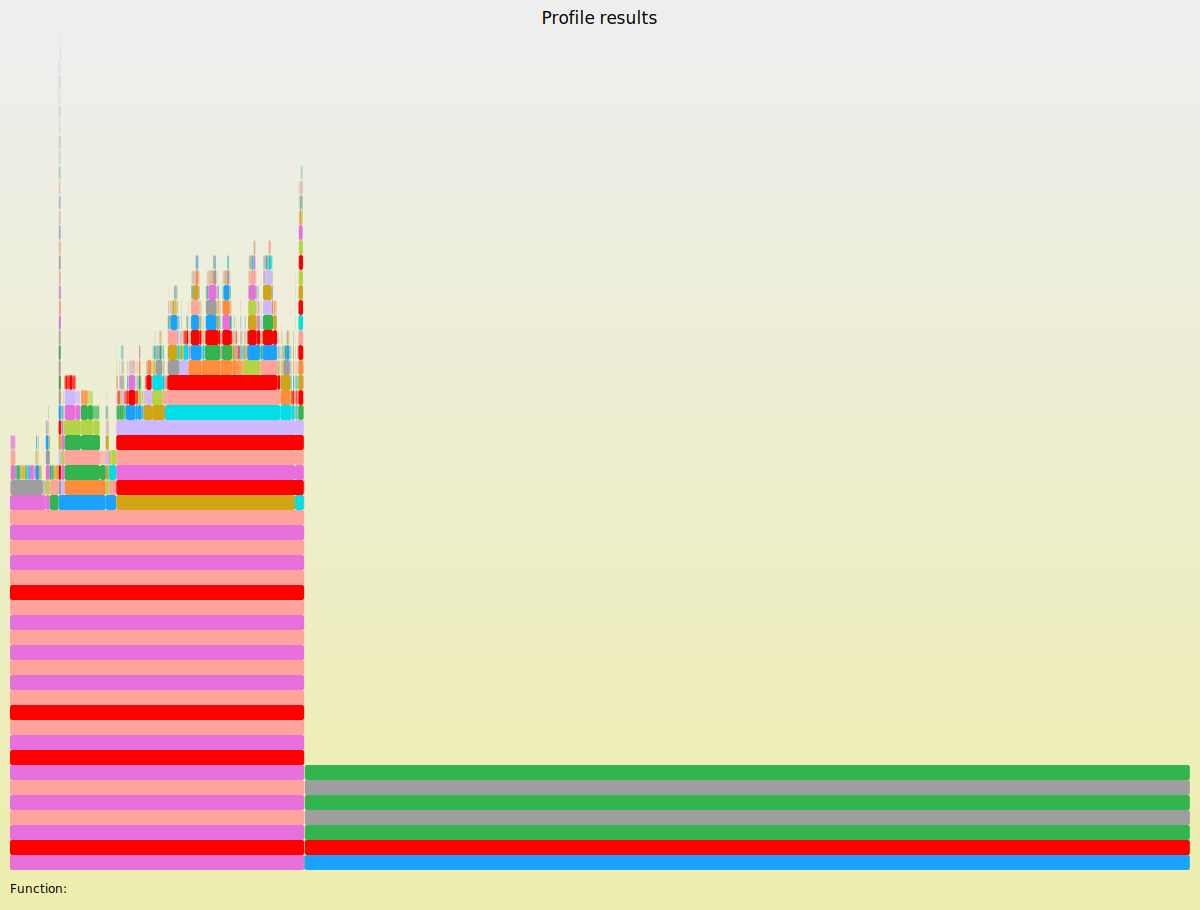

In [8]:
ProfileView.view(C=true)

## Gaining additional insights

Other profiling tools
1. https://github.com/cstjean/FProfile.jl
2. https://github.com/cstjean/TraceCalls.jl
3. Learn about Linux's `perf`

Code Analyzer
1. https://github.com/vchuravy/IACA.jl

## Threading
Julia threading model is based on a fork-join approach and is still considered experimental.
(So experimental in fact that these benchmarks have been run with https://github.com/JuliaLang/julia/pull/24688)

Fork-join describes the control flow that a group of threads undergoes. Execution is forked and a anonymous function is then run across all threads.

All threads have to join together and serial execution continues.

### Hardware

In [9]:
is_linux() && run(`lscpu`)

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                4
On-line CPU(s) list:   0-3
Thread(s) per core:    2
Core(s) per socket:    2
Socket(s):             1
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 79
Model name:            Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
Stepping:              1
CPU MHz:               2700.074
CPU max MHz:           3000.0000
CPU min MHz:           1200.0000
BogoMIPS:              4600.09
Hypervisor vendor:     Xen
Virtualization type:   full
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              46080K
NUMA node0 CPU(s):     0-3
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc aperfmperf eagerfpu pni pclmulqdq ssse3 f

```sh
> lscpu
...
Thread(s) per core:  2
Core(s) per socket:  2
...
Model name:          Intel(R) Core(TM) i7-7660U CPU @ 2.50GHz
...
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            4096K
...
Flags: ... avx2 ...
```

```sh
> lscpu
...
Thread(s) per core:  2
Core(s) per socket:  12
...
Model name:          AMD Ryzen Threadripper 1920X 12-Core Processor
...
L1d cache:           32K
L1i cache:           64K
L2 cache:            512K
L3 cache:            8192K
...
Flags: ... avx2 ...
```

In [10]:
using Base.Threads

In [11]:
nthreads()

4

Special care needs to be taken if the loop body access has side-effects or accesses global state. (This includes IO and random numbers)

In [12]:
function rand_init1(A)
    @threads for i in 1:length(A)
        A[i] = rand()
    end
end

rand_init1 (generic function with 1 method)

In [13]:
function rand_init2(rngs, A)
    @threads for i in 1:length(A)
        A[i] = rand(rngs[threadid()])
    end
end

rand_init2 (generic function with 1 method)

In [14]:
# Based on https://github.com/bkamins/KissThreading.jl/blob/8675f55ef9469fccf808a44237bd5f0bbb02b950/src/KissThreading.jl#L5-L15
function create_rngs()
    rngjmp = randjump(Base.GLOBAL_RNG, nthreads()+1)
    rngs = Vector{MersenneTwister}(nthreads())
    Threads.@threads for tid in 1:nthreads()
        rngs[tid] = deepcopy(rngjmp[tid+1])
    end
    all([isassigned(rngs, i) for i in 1:nthreads()]) || error("failed to create rngs")
    return rngs
end

create_rngs (generic function with 1 method)

In [15]:
basic_rngs = [MersenneTwister(rand(UInt64)) for i in 1:nthreads()]
proper_rngs = create_rngs();

In [16]:
A = zeros(10_000);

In [17]:
@benchmark rand_init1($A)

BenchmarkTools.Trial: 
  memory estimate:  32 bytes
  allocs estimate:  1
  --------------
  minimum time:     76.773 μs (0.00% GC)
  median time:      149.930 μs (0.00% GC)
  mean time:        150.099 μs (0.00% GC)
  maximum time:     198.623 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [18]:
@benchmark rand_init2($basic_rngs, $A)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  1
  --------------
  minimum time:     23.261 μs (0.00% GC)
  median time:      24.307 μs (0.00% GC)
  mean time:        24.292 μs (0.00% GC)
  maximum time:     145.660 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [19]:
@benchmark rand_init2($proper_rngs, $A)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  1
  --------------
  minimum time:     22.975 μs (0.00% GC)
  median time:      24.237 μs (0.00% GC)
  mean time:        24.254 μs (0.00% GC)
  maximum time:     50.971 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

## Atomics and Locks

In [20]:
acc = 0
@threads for i in 1:10_000
    global acc
    acc += 1
end

In [21]:
acc

2534

In [22]:
acc = Atomic{Int64}(0)
@threads for i in 1:10_000
    atomic_add!(acc, 1)
end

In [23]:
acc

Base.Threads.Atomic{Int64}(10000)

For locks take a look at the [manual](https://docs.julialang.org/en/latest/stdlib/parallel/#Synchronization-Primitives-1)

# A useful trick
```julia
@threads for id in 1:nthreads()
    #each thread does something
end
```

In [24]:
function threaded_sum(arr)
   @assert length(arr) % nthreads() == 0
   let results = zeros(eltype(arr), nthreads())
       @threads for tid in 1:nthreads()
           # split work
           acc = zero(eltype(arr))
           len = div(length(arr), nthreads())
           domain = ((tid-1)*len +1):tid*len
           @inbounds for i in domain
               acc += arr[i]    
           end
           results[tid] = acc
       end
       sum(results)
   end
end

threaded_sum (generic function with 1 method)

In [25]:
data = rand(3*2^19);

In [26]:
@btime sum($data)

  409.636 μs (0 allocations: 0 bytes)


786472.3368683406

In [27]:
@btime threaded_sum($data)

  440.189 μs (2 allocations: 160 bytes)


786472.3368683412

| NT  | Skylake | AMD TR |
| --- | --- | --- |
| sum | 514.476 μs | 430.409 μs |
| 1 | 1.578 ms | 1.206 ms |
| 2 | 831.411 μs | 575.872 μs |
| 4 | 417.656 μs | 294.724 μs |
| 6 | X | 215.986 μs |
| 12 | X | 109.536 μs |
| 24 | X | 57.197 μs |

If your `@threads` performance with one thread is not as fast as a non `@threads` version something is off..., but yeah for linear scaling.

In [28]:
function threaded_sum2(arr)
   @assert length(arr) % nthreads() == 0
   let results = zeros(eltype(arr), nthreads())
       @threads for tid in 1:nthreads()
           # split work
           acc = zero(eltype(arr))
           len = div(length(arr), nthreads())
           domain = ((tid-1)*len +1):tid*len
           @inbounds @simd for i in domain
               acc += arr[i]    
           end
           results[tid] = acc
       end
       sum(results)
    end
end

threaded_sum2 (generic function with 1 method)

In [29]:
@btime threaded_sum2($data)

  189.639 μs (2 allocations: 160 bytes)


786472.3368683401

| NT  | Skylake | AMD TR |
| --- | --- | --- |
| sum | 514.476 μs | 430.409 μs |
| 1 | 493.384 μs | 401.755 μs |
| 2 | 282.030 μs | 73.408 μs |
| 4 | 230.988 μs | 37.541 μs |
| 6 | X | 29.185 μs |
| 12 | X | 16.491 μs |
| 24 | X | 17.693 μs |

Hyperthreading...

and superlinear speedup from 1-2 threads on Threadripper, due to cache effect. (Data is 12MB; 2xL3 = 16MB)

## An example

In [30]:
function myfun(rng::MersenneTwister)
    s = 0.0
    N = 10000
    for i = 1:N
        s += det(randn(rng, 3,3))
    end
    s/N
end


myfun (generic function with 1 method)

In [31]:
function bench(rgi)
    a = zeros(1000)
    @threads for i = 1:length(a)
        a[i] = myfun(rgi[threadid()])
    end
end

bench (generic function with 1 method)

In [32]:
rgi = [MersenneTwister(rand(UInt)) for _ in 1:nthreads()];

In [33]:
@btime bench($rgi)

  3.837 s (46897551 allocations: 3.56 GiB)


### Steps I took to optimize this code

1. Memory allocations in hot-loop
2. Eliminate allocs caused by rand
3. Investigate how det is implemented
4. Implement det!
5. Remove overhead to library call
6. Use profiling tools
7. Start using StaticArrays

Full story here: https://hackmd.io/s/BkyZ5Mmbb

In [34]:
using StaticArrays

In [35]:
function myfun_fast(rng::MersenneTwister)
    s = 0.0
    N = 10000
    for i in 1:N
        s += det(randn(rng, SMatrix{3, 3}))
    end
    s/N
end

myfun_fast (generic function with 1 method)

In [36]:
function bench_fast(rgi)
    a = zeros(1000)
    @threads for i in 1:length(a)
        @inbounds a[i] = myfun_fast(rgi[threadid()])
    end
end

bench_fast (generic function with 1 method)

In [37]:
rgi_fast = create_rngs();

In [38]:
result = @btime bench_fast($rgi_fast)

  365.109 ms (2 allocations: 7.98 KiB)


## Distributed computing and accelerated computing
### The Julia way!

Julia supports various forms of distributed computing.

1. A native master-worker system based on remote procedure calls
2. MPI through `MPI.jl`
3. `DistributedArrays.jl`

Julia also has support for accelerated computing

1. Low-level (C kernel) based operations `OpenCL.jl` and `CUDAdrv.jl`
2. Low-level (Julia kernel) based operations through `CUDAnative.jl` and 
2. High-level vendor specific abstractions `CuArray.jl` and `CLArray.jl`
2. High-level libraries like `ArrayFire.jl` and `GPUArrays.jl`

### The Julia way! Tell us where your data is and your program will follow.

#### `broadcast` example

In [39]:
addprocs(4)

4-element Array{Int64,1}:
 2
 3
 4
 5

In [40]:
@everywhere using DistributedArrays
using CuArrays

 in module Interop at /home/ubuntu/.julia/v0.6/LLVM/src/interop/base.jl:54 overwritten in module CUDAnative at /home/ubuntu/.julia/v0.6/CUDAnative/src/cgutils.jl:159.


In [41]:
B = ones(10_000) ./ 2;
A = ones(10_000) .* π;

In [42]:
C = 2 .* A ./ B;
all(C .≈ 4*π)

true

In [43]:
typeof(C)

Array{Float64,1}

In [44]:
dB = distribute(B);
dA = distribute(A);

In [45]:
dC = 2 .* dA ./ dB;
all(dC .≈ 4*π)

true

In [46]:
typeof(dC)

DistributedArrays.DArray{Float64,1,Array{Float64,1}}

In [47]:
cuB = CuArray(B);
cuA = CuArray(A);

In [48]:
cuC = 2 .* cuA ./ cuB;
# Disclaimer on Julia v0.6 some operations don't work `sin`. Use CUDAnative.sin instead.
all(cuC .≈ 4*π)

true

In [49]:
typeof(cuC)

CuArray{Float64,1}

#### example powermethod

In [50]:
function power_method(M, v)
    for i in 1:100
        v = M*v        # repeatedly creates a new vector and destroys the old v
        v /= norm(v)
    end
    
    return v, norm(M*v) / norm(v)  # or  (M*v) ./ v
end

power_method (generic function with 1 method)

In [51]:
M = [2. 1; 1 1]
v = rand(2)

2-element Array{Float64,1}:
 0.0440707
 0.369138 

In [52]:
power_method(M, v)

([0.850651, 0.525731], 2.618033988749895)

In [53]:
cuM = CuArray(M);
cuv = CuArray(v);

In [54]:
curesult = power_method(cuM, cuv)

(CuArray([0.850651, 0.525731]), 2.618033988749895)

In [55]:
typeof(curesult[1])

CuArray{Float64,1}

In [ ]:
dM = distribute(M);
dv = distribute(v);

In [ ]:
result = power_method(dM, dv)

In [ ]:
typeof(result[1])